# Plots for the 2MDM analysis

In [9]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import re,os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from scipy.interpolate import griddata,interp1d
from itertools import product
from auxPlots import atlasCurve1,atlasCurve2,LZlimit,sigmaz_gev
import pyslha

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu_r']

### Load Relic Density scan 

In [10]:
scanLabel = 'scan2'
scanSummary = os.path.join('../data/maddmOutput/',scanLabel,'output/scan_run_01.txt')
with open(scanSummary,'r') as f:
    headerLines = [l for l in f.readlines() if l.strip() and l.strip()[0] == '#']
columnLabels = {eval(re.sub(r'\b0', '',h.split(':')[0].replace('[','').replace(']','').replace('#',''))) : 
                     h.split(':')[1].replace('\n','').strip().replace('%','pc') for h in headerLines}
header = ['']*len(columnLabels)
for i,label in columnLabels.items():
    header[i-1] = label
relicData = pd.read_csv(scanSummary,names=header,
                        comment='#',delimiter='\t',index_col=False)
# Remove unused columns:
relicData.drop(columns=[c for c in relicData.columns if 'pc_relic' in c]+['Nevents','smearing','xsi','x_f','sigmav(xf)'],inplace=True)
# Rename columns:
renameDict = {'Omegah^2' : 'Omegah2', 'mass#9000006' : 'mChi', 'mass#9900032' : 'mZp', 'mass#9900026' : 'mS'}
relicData.rename(columns=renameDict,inplace=True)
print(relicData.columns)

Index(['run', 'mChi', 'mS', 'mZp', 'Omegah2', 'sigmaN_SI_p', 'lim_sigmaN_SI_p',
       'sigmaN_SI_n', 'lim_sigmaN_SI_n', 'sigmaN_SD_p', 'lim_sigmaN_SD_p',
       'sigmaN_SD_n', 'lim_sigmaN_SD_n'],
      dtype='object')


### Get Model Parameters

In [11]:
modelPars = pyslha.readSLHAFile(os.path.join('../data/maddmOutput',scanLabel,'Cards/param_card.dat'))
gchi = modelPars.blocks['NPINPUTS'][1]
gq = modelPars.blocks['NPINPUTS'][2]
sina = modelPars.blocks['NPINPUTS'][3]
# mS = modelPars.blocks['MASS'][9900026]


textstr = '\n'.join((
    r'$m_S = (m_{Z^\prime} + m_{\chi})/2$',
    r'$g_q =$ %1.2f' %gq,
    r'$g_\chi =$ %1.2f' %gchi,
    r'$\sin\alpha =$ %1.1f' %sina))


### Compute r-values

In [12]:
# Compute r values:
relicData['r_omega'] = relicData['Omegah2']/0.12
dd_rescaling = (np.minimum(1.0,relicData['r_omega']))
relicData['r_SI_p'] = dd_rescaling*relicData['sigmaN_SI_p']/relicData['lim_sigmaN_SI_p']
relicData['r_SI_n'] = dd_rescaling*relicData['sigmaN_SI_n']/relicData['lim_sigmaN_SI_n']
relicData['r_SD_p'] = dd_rescaling*relicData['sigmaN_SD_p']/relicData['lim_sigmaN_SD_p']
relicData['r_SD_n'] = dd_rescaling*relicData['sigmaN_SD_n']/relicData['lim_sigmaN_SD_n']
relicData['r_SI_LZ'] = dd_rescaling*relicData['sigmaN_SI_p']/LZlimit(relicData['mChi'])

#### Add limits from v-suppressed sigmaN

In [13]:
relicData['sigmaN_SI_v'] = sigmaz_gev(relicData['mChi'],relicData['mS'],relicData['mZp'],sina=sina,gchi=gchi,gq=gq)
relicData['r_SIv_LZ'] = dd_rescaling*relicData['sigmaN_SI_v']/LZlimit(relicData['mChi'])

### Compute maximum r-value

In [14]:
rList = ['r_omega','r_SI_p','r_SD_p','r_SI_LZ','r_SIv_LZ']
# rList = ['r_omega','r_SIv_LZ']
relicData['r_dm'] = relicData[rList].values.max(1)

/tmp/ipykernel_38108/3316111303.py:53: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


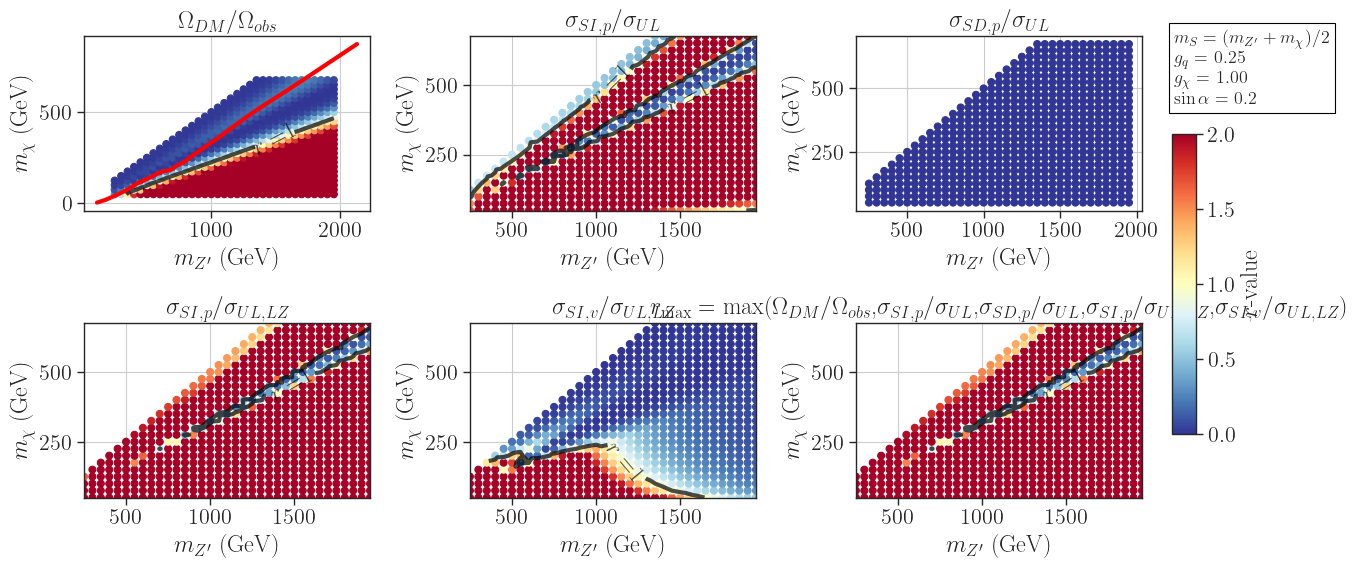

In [15]:
xLabels = {'mZp' : r'$m_{Z^\prime}$ (GeV)'}
yLabels = {'mChi' : r'$m_{\chi}$ (GeV)'}
zLabels = {'r_omega' : r'$\Omega_{DM}/\Omega_{obs}$',
           'r_SI_p' : r'$\sigma_{SI,p}/\sigma_{UL}$',
           'r_SD_p' : r'$\sigma_{SD,p}/\sigma_{UL}$',
           'r_SI_LZ' : r'$\sigma_{SI,p}/\sigma_{UL,LZ}$',
           'r_SIv_LZ' : r'$\sigma_{SI,v}/\sigma_{UL,LZ}$'
           }
zLabels['r_dm'] = r'$r_{\rm max}$ = max(%s)' %(','.join([zLabels[z] for z in rList]))

allPlots = list(product(xLabels.keys(),yLabels.keys(),zLabels.keys()))
nplots = len(allPlots)
ncols = 3
nrows =  (int(nplots/ncols))
if nrows*ncols < nplots: 
    nrows += 1

fig,axarr = plt.subplots(nrows=nrows,ncols=ncols,figsize=(4*ncols,3*nrows))
axarr = np.array(axarr).reshape(-1)

for iplot,(xLabel,yLabel,zLabel) in enumerate(allPlots):
    ax = axarr[iplot]

    p = ax.scatter(relicData[xLabel],relicData[yLabel],c=relicData[zLabel],s=25,
            cmap=cm, vmin=0.0,vmax=2.0)

    pts = np.array([y for y in product(np.unique(relicData[xLabel]),np.unique(relicData[yLabel]))])
    rPts = griddata(list(zip(relicData[xLabel],relicData[yLabel])),relicData[zLabel],pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    if (max(rPts) > 1.0 and min(rPts) < 1.0):
        cs = ax.tricontour(pts[:,0],pts[:,1], rPts, levels=[1.0], alpha=0.7,linewidths=3,colors='black')
        ax.clabel(cs, levels= [1.0], inline=True, fmt=r'$r = $%1.0f')
    if zLabel == 'r_omega':
        ax.plot(atlasCurve1[:,0],atlasCurve1[:,1],color='red',linewidth=3)
        # ax.plot(atlasCurve2[:,0],atlasCurve2[:,1],color='red',linewidth=3)
    
    
    ax.set_xlabel(xLabels[xLabel])
    ax.set_ylabel(yLabels[yLabel])
    ax.set_title(zLabels[zLabel])
    # ax.set_xlim(50.0,1.1*x.max())
    # ax.set_ylim(5.0,1.1*y.max())
    # ax.legend()
    ax.grid()

fig.subplots_adjust(right=0.92,top=1.1)
cbar_ax = fig.add_axes([0.99, 0.25, 0.02, 0.5]) 
fig.colorbar(p,label=r'$r$-value',cax=cbar_ax)

plt.text(0.1,1.1,textstr,fontsize=13,bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)
plt.tight_layout()
plt.show()    

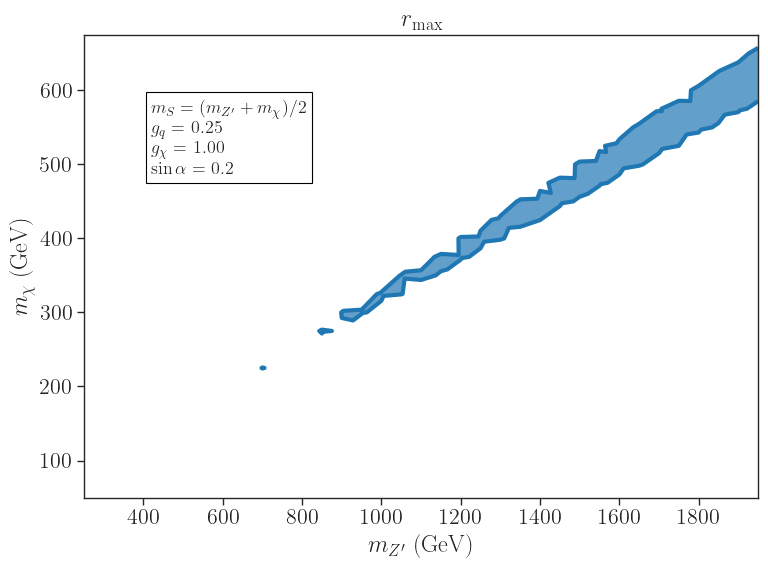

In [16]:
xLabels = {'mZp' : r'$m_{Z^\prime}$ (GeV)'}
yLabels = {'mChi' : r'$m_{\chi}$ (GeV)'}
zLabels = {'r_dm' : r'$r_{\rm max}$'}

allPlots = list(product(xLabels.keys(),yLabels.keys(),zLabels.keys()))
nplots = len(allPlots)
ncols = 1
nrows =  (int(nplots/ncols))
if nrows*ncols < nplots: 
    nrows += 1

fig,axarr = plt.subplots(nrows=nrows,ncols=ncols,figsize=(8,6))
axarr = np.array(axarr).reshape(-1)

for iplot,(xLabel,yLabel,zLabel) in enumerate(allPlots):
    ax = axarr[iplot]

    pts = np.array([y for y in product(np.unique(relicData[xLabel]),np.unique(relicData[yLabel]))])
    rPts = griddata(list(zip(relicData[xLabel],relicData[yLabel])),relicData[zLabel],pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    if (max(rPts) > 1.0 and min(rPts) < 1.0):
        cs = ax.tricontour(pts[:,0],pts[:,1], rPts, levels=[1.0], alpha=1.0,linewidths=3,colors=sns.color_palette())
        cs = ax.tricontourf(pts[:,0],pts[:,1], rPts, levels=[0.0,1.0], alpha=0.7,colors=sns.color_palette())
    
    
    ax.set_xlabel(xLabels[xLabel])
    ax.set_ylabel(yLabels[yLabel])
    ax.set_title(zLabels[zLabel])


plt.text(0.1,0.7,textstr,fontsize=13,bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)
plt.tight_layout()
plt.show()    